In [1]:
import numpy as np
from time import time
from PIL import Image
import torch
import torch.nn as nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
from backbones import get_model
from privacy_pipeline import Pipeline
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchvision.utils import save_image
from IPython.display import Image as showIm
from IPython.display import display
DEVICE = torch.device("cuda")
net = get_model('r100',fp16=False).eval().to(DEVICE)
net.load_state_dict(torch.load('/private/data/backbone.pth'))
batch_size = 80
image_dim = 112
def tensorToImage(im):return ((im+1)/2).permute(1, 2, 0).cpu().detach().numpy()
def get_emb_center():
    for X in l:
        xx = X.sum(dim=0,keepdim=True)/X.shape[0]
        print(xx.shape)
        emb=F.normalize(net(xx))
        emb_center=torch.load('save/emb_average.pt')
        print((emb**2).sum(),(emb_center**2).sum())
        print((emb*emb_center).sum())
        # plt.imshow(tensorToImage(xx[0]))
        # plt.show()
        break

In [2]:
def calculate_channel_colors():
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np
    #用直方图分别统计图像各个像素三个颜色通道数值数量的分布
    img = cv2.imread('images/0.jpg')
    # cv2.imshow('img',img)
    color = ('blue','green','red')
    #enumerate函数第一个返回索引index，第二个返回元素element
    for i,color in enumerate(color):
        #参数说明：
        #一、images（输入图像）参数必须用方括号括起来。
        #二、计算直方图的通道。
        #三、Mask（掩膜），一般用None，表示处理整幅图像。
        #四、histSize，表示这个直方图分成多少份（即多少个直方柱）。
        #五、range，直方图中各个像素的值，[0.0, 256.0]表示直方图能表示像素值从0.0到256的像素。
        hist = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(hist,color = color)
        plt.xlim([0,256])
    plt.show()

In [3]:
def get_emb_1():
    with torch.no_grad():
        for i in train_loader:
            l = i[0]
            break
        emb_target = net(l)
    #     print(emb_target,torch.norm(emb_target))
    inputs = l
    # inputs[:] = (inputs + torch.flip(inputs,[3]))/2
    inputs[:] = torch.flip(inputs, dims=(3,))
    color = {'blue','green','red'}
    plt.imshow(tensorToImage(inputs[0]))
    plt.show()
    # plt.hist(l[0].cpu().detach().numpy().reshape(-1),range=(-1.2,1.2),bins=100)
    # plt.show()
    emb_target
    torch.save(emb_target.cpu(),'save/emb_1.pt')

In [4]:
emb_target = torch.load('save/emb_1.pt').cuda()
pipeline = Pipeline(emb_target,
                    net,
                    DEVICE,
                    dim=image_dim,
                    batch_size=batch_size,
                    sym_part=1,
                    multistart=True,
                    gauss_amplitude=0.04,
                    color=False,
                    )

In [5]:
(emb_target**2).sum()

tensor(621.8265, device='cuda:0')

In [6]:
cosines_target = []
facenet_sims = []

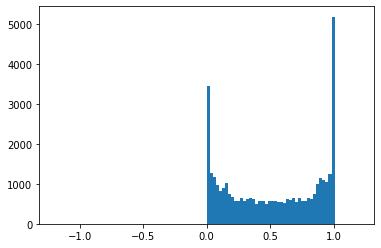

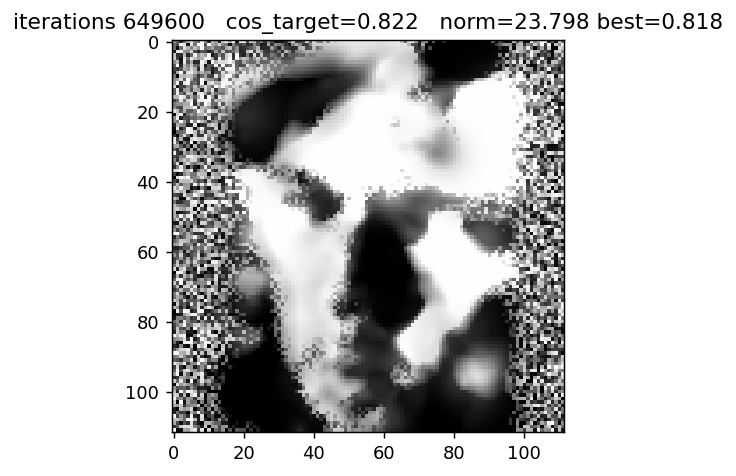

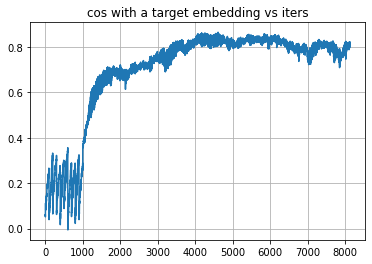

KeyboardInterrupt: 

In [7]:
pipeline = Pipeline(emb_target,
                    net,
                    DEVICE,
                    dim=image_dim,
                    batch_size=batch_size,
                    sym_part=0,
                    multistart=True,
                    gauss_amplitude=0.5,
                    color=False,
                    )
with torch.no_grad():
    for i in range(15000):
        start = time()
        
        recovered_face, cos_target ,norms = pipeline()
        
        cosines_target.append(cos_target)
        
        
        if i % 20 == 0:
            clear_output(wait=True)
            plt.hist(recovered_face.cpu().detach().numpy().reshape(-1),range=(-1.2,1.2),bins=100)
            plt.show()
            recovered_face = np.transpose(recovered_face.cpu().detach().numpy(),(1,2,0))
            recovered_face = recovered_face - np.min(recovered_face)
            recovered_face = recovered_face / np.max(recovered_face)
#             plt.hist(recovered_face.reshape(-1),bins=100,range=(-1,1))
#             plt.show()
            
            plt.figure(dpi=130)
            plt.imshow(recovered_face)
            plt.title(f"iterations {i*pipeline.batch_size}   cos_target={round(cos_target,3)}   norm={round(pipeline.norm,3)} best={(round(pipeline.best_value.item(),3))}")
            plt.show()
            
            plt.plot(cosines_target)
            plt.grid()
            plt.title("cos with a target embedding vs iters")
            plt.show()
# gauss 取值为0.1的amplitude 出来这样

In [ ]:
dim = 112
edge = 20
up = 5
bs = 64
sys_part = 1 
gauss_amplitude = 0.02
color = False
n_restart = 10
best_multi_face = None
best_multi_cos = -1
iters = 0
iters_before_restart = 100
emb_target = emb_target.expand(bs,-1).cuda()
face = torch.zeros((bs,3,dim,dim)).cuda()
x, y = np.meshgrid(np.linspace(0,dim,dim),np.linspace(0,dim,dim))
x_grid = torch.FloatTensor(x).expand(bs,dim,dim).cuda()
y_grid = torch.FloatTensor(y).expand(bs,dim,dim).cuda()
best_inv = None
best_value = 0
global_best_value = -1
best_cos = -1
norm = None
objective = 0

In [ ]:
def gauss_2d(dim_x,dim_y,x_coord,y_coord,sigma1,sigma2,A):
    x = x_grid.T
    y = y_grid.T

    sigma1 = sigma1.expand(dim_x,bs).cuda()
    sigma2 = sigma2.expand(dim_x,bs).cuda()
    x_coord = x_coord.expand(dim_x,bs).cuda()
    y_coord = y_coord.expand(dim_x,bs).cuda()

    g_x = torch.exp( - (x[:,0] - x_coord) ** 2 / (2 * sigma1 ** 2)).expand(dim_x,dim_y,bs)
    g_y = torch.exp( - (y[0] - y_coord) ** 2 / (2 * sigma2 ** 2)).expand(dim_y,dim_x,bs)

    g_y = torch.transpose(g_y,0,1)

    A = A.expand(dim_x,bs)
    A = A.expand(dim_x,bs)
    A = A.expand(dim_y,dim_x,bs)
    g = A.cuda() * g_x * g_y
    g = g.permute(2,0,1)

    return g
w = torch.rand(bs)*30

A = torch.rand(bs)
g = gauss_2d(dim,dim,x,y,w,w,A)
epoch = 100
print(g.shape)
g = g.reshape(64,1,112,112)
save_image(g.data.clone(),f'img/{epoch:04d}.png',normalize=True,nrow=8)
display(showIm(filename=f'img/{epoch:04d}.png'))

In [ ]:
x = torch.FloatTensor(bs).uniform_(edge,dim-edge)
y = torch.FloatTensor(bs).uniform_(up,dim)

In [ ]:
x,y

In [ ]:
b = torch.rand(64) >0.5

In [ ]:
b = b.type_as(a)

In [ ]:
a = torch.rand(100)

In [ ]:
b = (b-0.5)/2

In [ ]:
b*4